In [9]:
import numpy as np
import h5py
import scipy
from scipy.signal import wiener, medfilt
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from skimage.color import label2rgb
import os
%matplotlib inline

In [10]:
ct_data, pet_data, label_data = [], [], []
num_data = 2
with h5py.File(os.path.join('..','input','lab_petct_vox_5.00mm.h5'),'r') as p_data:
    for ct_img, pet_img, label in zip(p_data['ct_data'].values(),
                                      p_data['pet_data'].values(),
                                      p_data['label_data'].values()):
        ct_data += [np.array(ct_img)]
        pet_data += [np.array(pet_img)]
        label_data += [np.array(label)]
        num_data = num_data - 1
        if num_data == 0:
            break

In [11]:
len(ct_data)

2

In [12]:
ct_cubes, pet_cubes,lab_cubes = [], [], []
tile_size=16
stride=3
for ct_img, pet_img, label in zip(ct_data, pet_data, label_data):
    for i in range(0,  ct_img.shape[0], tile_size):
        for j in range(0,  ct_img.shape[1], tile_size):
            for z in range(0,  ct_img.shape[2], tile_size):
                for i_k in range(0, tile_size, stride):
                    for j_k in range(0, tile_size, stride):
                        for z_k in range(0,tile_size,stride):
                            ct_cubes += [ct_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]]
                            pet_cubes += [pet_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]]
                            lab_cubes += [label[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]] 

In [33]:
# The following functions take a cube and an axis and return a projection of the tile along the axis
from sklearn.preprocessing import normalize

def reduceCTCube(cube,axis):
    return np.sum(cube,axis)
    
def reducePETCube(cube,axis):
    #if(np.sqrt(np.max(cube,axis)==nan)):
        #print(mk,axis)
    cube_array=np.sqrt(np.max(cube,axis))
    where_are_NaNs = np.isnan(cube_array)
    #print([where_are_NaNs])
    cube_array[where_are_NaNs] = 0.001386386961242742
    #return np.sqrt(np.max(cube,axis))
    #if np.any(np.isnan(cube_array)):
        #print('sad')
    return cube_array
    
def reduceLabelCube(cube):
    # write here, returns a single value, not a list/array    
    return(np.mean(cube))
        
        
    


In [39]:
print(data_tiles[0])
print(normalize(data_tiles[0][:,np.newaxis], axis=0).ravel())

[  2.79469128e-02   6.15916085e-02   4.52784883e-02 ...,  -1.59999941e+04
  -1.59544941e+04  -1.59490742e+04]
[  6.30487630e-08   1.38951832e-07   1.02149125e-07 ...,  -3.60962890e-02
  -3.59936401e-02  -3.59814127e-02]


In [40]:
data_tiles, data_labels = [], []

n_ct_cubes = [c_tile for c_tile in ct_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]
n_pet_cubes = [c_tile for c_tile in pet_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]
n_lab_cubes = [c_tile for c_tile in lab_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]

#ct_cube_final, pet_cube_final, lab_cube_final = zip(*[(c_cube, p_cube, l_cube) 
      #for c_cube, p_cube, l_cube in zip(n_ct_cubes, n_pet_cubes, n_lab_cubes)
     #if np.mean(c_cube) > -1001 and np.mean(p_cube) > .0002])
#print('%d tiles removed' % (len(n_ct_cubes)-len(ct_cube_final)))

#print(len(pet_cube_final))

#for ct_cube, pet_cube, lab_cube in zip(ct_cube_final, pet_cube_final,lab_cube_final):
#mk=0
for ct_cube, pet_cube, lab_cube in zip(n_ct_cubes, n_pet_cubes,n_lab_cubes):
    data_tile = []
    for axis in range(3):
        a=reducePETCube(pet_cube, axis).flatten()
        data_tile = np.concatenate([data_tile, a])
                
    #mk=mk+1
    #print()
    data_tiles += [data_tile]
    data_labels += [reduceLabelCube(lab_cube)]
    

C:\Users\Himanshu\Miniconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


In [32]:
print(len(data_tiles[0]))

1536


In [24]:
lab_class = [c_score > 0 for c_score in data_labels]
from sklearn.model_selection import train_test_split
train_tiles, test_tile, train_score, test_score = train_test_split(data_tiles, data_labels, 
                                                                   train_size = 0.8, stratify = lab_class, random_state = 1234)
#print('Training size', train_tiles.shape, 'Testing size', test_tile.shape)
#print('Train tumor tiles', np.where(train_score), 'Test tumor tiles', np.where(test_score))

In [25]:
from sklearn.neighbors import KNeighborsRegressor
knn1_model = KNeighborsRegressor(1, algorithm = 'brute',n_jobs=4)

In [26]:
knn1_model.fit(train_tiles, train_score)

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=4, n_neighbors=1, p=2,
          weights='uniform')

In [27]:
n = 1000
i = 0
print(len(test_tile))
test_predictions = []
while(True):
    test_t = test_tile[i:i+n]
    i += n
    print(i)
    test_p = knn1_model.predict(test_t)
    test_predictions.append(test_p) 
    if( i > len(test_tile)):
        break
    

24576
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [28]:
test_predictions = np.concatenate(test_predictions) 
n = test_predictions.shape[0]

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(test_score[:n])>0, np.array(test_predictions)>0)

array([[24226,    31],
       [   50,   269]])

(-0.1, 1.1)

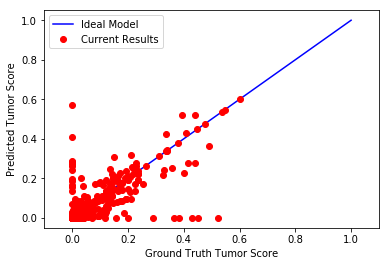

In [30]:
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1], [0,1], 'b-', label = 'Ideal Model')
ax1.plot(test_score[:n], test_predictions, 'ro', label = 'Current Results')
ax1.set_xlabel('Ground Truth Tumor Score')
ax1.legend()
ax1.set_ylabel('Predicted Tumor Score')
ax1.set_xlim(-0.1,1.1)

In [31]:
from sklearn.metrics import roc_auc_score, f1_score, brier_score_loss
rscore=roc_auc_score(np.array(test_score[:n])>0, np.array(test_predictions)>0)
print(rscore)
f1score = f1_score(np.array(test_score[:n])>0, np.array(test_predictions)>0)
print(f1score)
bscore = brier_score_loss(np.array(test_score[:n])>0, np.array(test_predictions)>0)
print(bscore)

0.920991103237
0.869143780291
0.0032958984375


In [ ]:
2 patients w/o black tile removal pet and ct